In [ ]:
!pip install --quiet tensorflow tensorflow_hub tensorflow_text pandas numpy matplotlib seaborn transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
df = pd.read_csv('data.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df.groupby('label').describe()

Unnamed: 0                                                         \
           count         mean          std  min     25%     50%     75%   
label                                                                     
ham       4825.0  2793.421762  1604.646764  0.0  1409.0  2794.0  4184.0   
spam       747.0  2734.331995  1634.377702  2.0  1227.0  2718.0  4149.5   

               
          max  
label          
ham    5571.0  
spam   5567.0

**Dataset**

In [ ]:
df.head()

,Unnamed: 0,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


Conversion of Label from Str to Bool

In [ ]:
df['label'] = np.where(df['label'] == 'spam', 1, 0)

In [ ]:
# Split the dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# Load the BERT tokenizer and encoder
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert_encoder = transformers.TFBertModel.from_pretrained('bert-base-uncased')

# Define the input pipelines
max_length = 128
batch_size = 32

train_encodings = tokenizer(list(train_text), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(list(val_text), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_text), truncation=True, padding=True, max_length=max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Define the model architecture
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

bert_outputs = bert_encoder(input_ids, attention_mask=attention_mask)
pooled_output = bert_outputs[1]

dropout = tf.keras.layers.Dropout(0.3)(pooled_output)
dense = tf.keras.layers.Dense(256, activation='relu')(dropout)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 5
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


122/122 [==============================] - 160s 824ms/step - loss: 0.1294 - accuracy: 0.9592 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 2/5
122/122 [==============================] - 101s 831ms/step - loss: 0.0296 - accuracy: 0.9923 - val_loss: 0.0402 - val_accuracy: 0.9880
Epoch 3/5
122/122 [==============================] - 100s 817ms/step - loss: 0.0106 - accuracy: 0.9977 - val_loss: 0.0337 - val_accuracy: 0.9928
Epoch 4/5
122/122 [==============================] - 102s 834ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0566 - val_accuracy: 0.9904
Epoch 5/5
122/122 [==============================] - 101s 825ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.0454 - val_accuracy: 0.9916


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

27/27 [==============================] - 10s 266ms/step - loss: 0.0153 - accuracy: 0.9976
Test Loss: 0.015344330109655857
Test Accuracy: 0.9976076483726501


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(val_dataset)
y_pred = np.round(y_pred).flatten()


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/27 [==============================] - 15s 267ms/step


In [ ]:
cm = confusion_matrix(test_labels, y_pred)
print(cm)

[[626  98]
 [ 99  13]]


In [ ]:
true_pos = cm[0][0]
false_pos =  cm[0][1]
false_neg = cm[1][0] 
true_neg = cm[1][1]

In [ ]:
prescision = true_pos / (true_pos + false_pos)
prescision

0.8646408839779005

In [ ]:
recall = true_pos / (true_pos + false_neg)
recall

0.863448275862069

In [ ]:
f1_score = 2 * ((prescision * recall) / (prescision + recall ))
f1_score

0.8640441683919944

In [ ]:
from sklearn.metrics import cohen_kappa_score


In [ ]:
kappa = cohen_kappa_score(val_labels, y_pred)
kappa

0.9637790596915154

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



In [ ]:
fpr, tpr, thresholds = roc_curve(val_labels, y_pred)

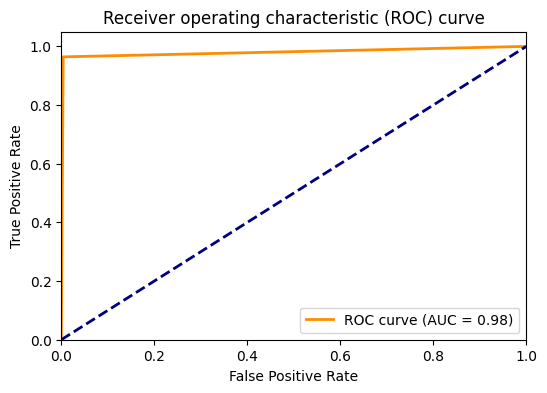

In [ ]:
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()